In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)

def coupled_spectrum(phi_ex,beta,N,Ej,Ec,omega_c):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    
    cdim = 10
    c = annihilation(sdim)
    cd = creation(sdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int =  0.1*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    H_int = g_int*np.kron(s+sd,cd+c)
#     H_int = g_int*(np.kron(sd,c)+np.kron(s,cd))
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact = energy[1]/2/np.pi
    return exact

def energy_der(phi_ex,beta,N,Ej,Ec,omega_c):
    energy_der = ad.grad(coupled_spectrum)
    return energy_der(phi_ex,beta,N,Ej,Ec,omega_c)

def g3g4(phi_ex,beta,N,Ej,Ec,omega_c):
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-3*np.cos((phi)/3))
    phi_min = sci.optimize.minimize(U_s,0).x
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    sixd = ad.grad(fived)
    sevend = ad.grad(sixd)
    eightd = ad.grad(sevend)
    c2 = secondd(phi_min[0])
    c3 = thirdd(phi_min[0])/3/2
    c4 = fourd(phi_min[0])/4/3/2
    c5 = fived(phi_min[0])/5/4/3/2
    c6 = sixd(phi_min[0])/6/5/4/3/2
    c7 = sevend(phi_min[0])/7/6/5/4/3/2
    c8 = eightd(phi_min[0])/8/7/6/5/4/3/2
    
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/Ej/c2,1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3
    g4 = Ej*phi_zpf**4*c4
    
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy,dressed_states = np.linalg.eigh(Hs)
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]
    return g3/2/np.pi,g4/2/np.pi,omega_s/2/np.pi

def sweep(phi_ex,beta,omega_c):
    Ej = 90*2*np.pi
    Ec = 0.177*2*np.pi
    N = 3
    der = energy_der(phi_exs[i],beta,N,Ej,Ec,omega_c)
    g3,g4,omega_sps = g3g4(phi_exs[i],beta,N,Ej,Ec,omega_c)
    kerr = g4s-5*g3s**2/omega_sps
    return der, g3, kerr

def cost(x0):
    phi_ex,beta,omega_c = x0
    Ej = 90*2*np.pi
    Ec = 0.177*2*np.pi
    N = 3
    der = energy_der(phi_ex,beta,N,Ej,Ec,omega_c)
    g3,g4,omega_sp = g3g4(phi_ex,beta,N,Ej,Ec,omega_c)
    kerr = g4-5*g3**2/omega_sp
    loss = der**2+kerr**2-g3**2
    return loss

In [2]:
import autograd.numpy as np

# Define the bounds
x_bounds = (0, 0.5 * 2 * np.pi)
y_bounds = (0, 0.3)
z_bounds = (0, 5 * 2 * np.pi)
bounds = [x_bounds,y_bounds,z_bounds]
# Define the number of points for each variable
N_x = 10  # You can change this value as needed
N_y = 5   # You can change this value as needed
N_z = 25  # You can change this value as needed

# Create linear spaces for x, y, and z
x_values = np.linspace(x_bounds[0], x_bounds[1], N_x)
y_values = np.linspace(y_bounds[0], y_bounds[1], N_y)
z_values = np.linspace(z_bounds[0], z_bounds[1], N_z)

# Generate combinations of (x, y, z)
combinations = [(x, y, z) for x in x_values for y in y_values for z in z_values]

In [ ]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=3)(delayed(sci.optimize.minimize)(cost, combo, bounds=bounds) for combo in combinations)

In [16]:
beta = 0.15
omega_c = 4*2*np.pi
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
snail_energiesapp1 = np.zeros(len(phi_exs))
snail_energiesapp2 = np.zeros(len(phi_exs))
snail_energiesapp3 = np.zeros(len(phi_exs))
dressed_omegas = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
omega_sps = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    snail_energies[i] = energy_der(phi_exs[i],beta,N,Ej,Ec,omega_c)
    g3s[i],g4s[i],omega_sps[i] = g3g4(phi_exs[i],beta,N,Ej,Ec,omega_c)

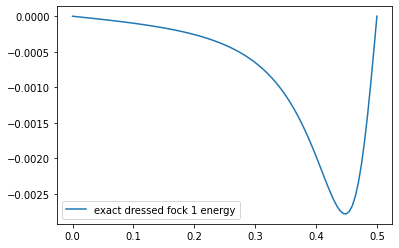

In [17]:
plt.plot(phi_exs/2/np.pi,snail_energies,label = 'exact dressed fock 1 energy')
# plt.scatter((phi_exs/2/np.pi)[-13],snail_energies[-14])
# plt.plot(phi_exs/2/np.pi,snail_energiesapp1, label = '$g^2/\Delta$')
# plt.plot(phi_exs/2/np.pi,snail_energiesapp2, label = '$g^2/\Delta - g^2/(\omega_c+\omega_s)$')
# plt.plot(phi_exs/2/np.pi,snail_energiesapp3, label = '$g^2/\Delta^{\'} - g^2/(\omega_c+\omega_s^{\'})$')
plt.legend()

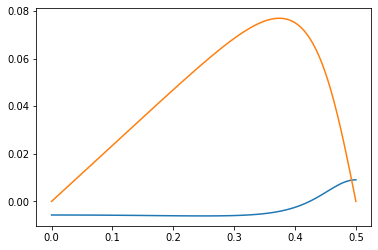

In [25]:
plt.plot(phi_exs/2/np.pi,g4s-5*g3s**2/omega_sps)
plt.plot(phi_exs/2/np.pi,g3s)